# This notebook calculates and plots sea ice cover and extent climatologies from the historical runs.
## author: Brian Green

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore")
import xarray as xr
import intake
import numpy as np
import matplotlib.pyplot as plt

# specific plotting stuff from Lettie
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util
import xesmf as xe

# Find models and experiments.

In [2]:
# Access the pangeo cmip6 archive
col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
#col.df.head() # this shows the fields that are available for querying

# query the archive to see what models, experiments, output, etc.
# frequencies are available
import pprint 
uni_dict = col.unique(['experiment_id'])
pprint.pprint(uni_dict, compact=True)

# find a specific experiment, output frequency, variable, and grid
cat = col.search(experiment_id=['historical'], table_id=['SImon'], variable_id=['siconc'], grid_label=['gn'], member_id=['r1i1p1f1'])
#cat.df

# using intake-esm, create a 'dictionary' of the files that I can then individually query
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})
#dset_dict.keys() # list the files
nmodels = len(dset_dict.keys())

{'experiment_id': {'count': 29,
                   'values': ['ssp370', 'esm-ssp585', '1pctCO2-bgc', 'hist-bgc',
                              '1pctCO2', 'abrupt-4xCO2', 'historical',
                              'piControl', 'amip', 'esm-hist', 'esm-piControl',
                              'hist-GHG', 'hist-aer', 'hist-nat', 'dcppA-assim',
                              'dcppA-hindcast', 'dcppC-hindcast-noAgung',
                              'dcppC-hindcast-noElChichon',
                              'dcppC-hindcast-noPinatubo', 'highresSST-present',
                              'control-1950', 'hist-1950', 'deforest-globe',
                              'esm-ssp585-ssp126Lu', 'omip1', 'lgm', 'ssp126',
                              'ssp245', 'ssp585']}}
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 11 group(s)


# Calculate the climatological sea ice cover for a given month for a specified number of years.

CAMS-CSM1-0
Reuse existing file: nearest_s2d_200x360_160x360_peri.nc
CanESM5
Reuse existing file: nearest_s2d_291x360_160x360_peri.nc
EC-Earth3-Veg
Reuse existing file: nearest_s2d_292x362_160x360_peri.nc
IPSL-CM6A-LR
Reuse existing file: nearest_s2d_332x362_160x360_peri.nc
MIROC6
Reuse existing file: nearest_s2d_256x360_160x360_peri.nc
MRI-ESM2-0
Reuse existing file: nearest_s2d_363x360_360x160_peri.nc
CESM2
Reuse existing file: nearest_s2d_384x320_360x160_peri.nc
CESM2-WACCM
Reuse existing file: nearest_s2d_384x320_360x160_peri.nc
GFDL-CM4
Reuse existing file: nearest_s2d_1080x1440_160x360_peri.nc
NESM3
Reuse existing file: nearest_s2d_384x320_360x160_peri.nc
SAM0-UNICON
Reuse existing file: nearest_s2d_384x320_360x160_peri.nc


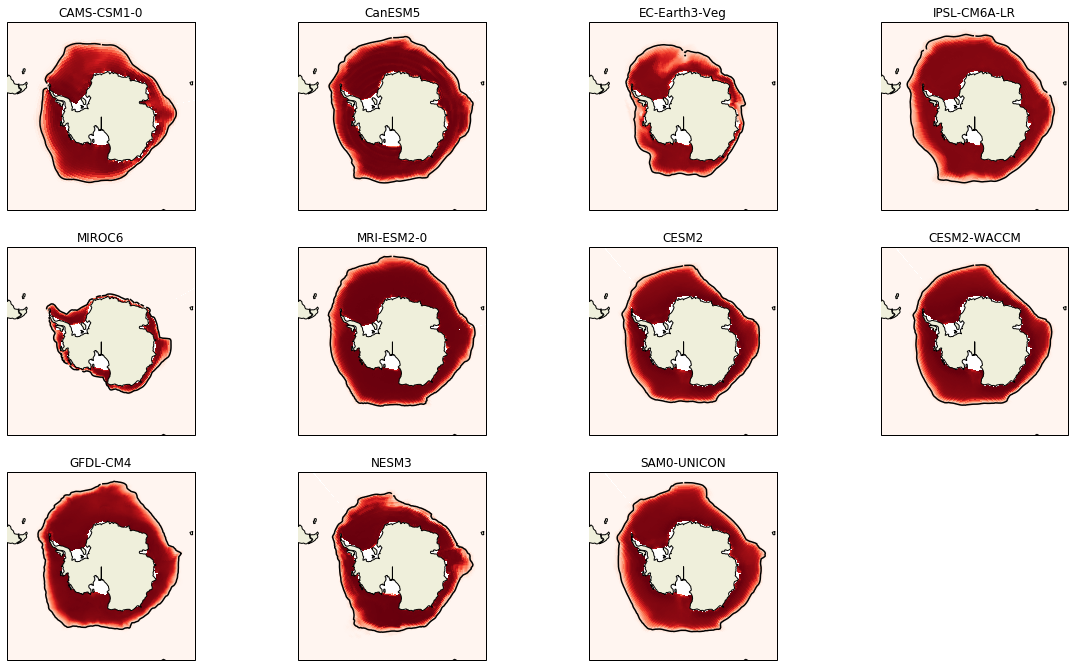

In [3]:
# Time info for calculating a climatology: all models' historical runs' output
# begins on January 1850, so figure out the indices that correspond to the months
# you want to average
year_start = 1986
nyears = 10 # number of years, beginning on year_start, to make the climatology for
clim_month = 7 # the month to make the climatology for (0: January)
months = clim_month+12*np.arange(nyears) + 12*(year_start-1850) # the indices to be used later

# New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
# concentration for the contour plot (otherwise the contour will reverse on itself)
res_new = 1 #degrees; the resolution of the new grid
lat_new = -80 + res_new/2 + np.arange(2*80/res_new) # only go from 80S to 80N
lon_new = res_new/2 + np.arange(360/res_new)
lon_new, lat_new = np.meshgrid(lon_new,lat_new)

ice_edge_conc = 15 # the concentration threshold for the sea ice edge
index = 0 # dummy index
fig = plt.figure(figsize=(20,20))
for i in dset_dict:
    print(dset_dict[i].source_id) # to make sure the calculation hasn't stalled
    
    # Deal with diferent names for latitude and longitude coordinates
    if 'latitude' in dset_dict[i]:
        latitude = dset_dict[i].latitude
        longitude = dset_dict[i].longitude
    elif 'lat' in dset_dict[i]:
        latitude = dset_dict[i].lat
        longitude = dset_dict[i].lon
    else:
        latitude = dset_dict[i].nav_lat
        longitude = dset_dict[i].nav_lon
        
    # Deal with multiple ensemble members, 1D grid vectors
    if latitude.ndim==3:
        latitude = np.squeeze(np.array(latitude[0,:,:]))
        longitude = np.squeeze(np.array(longitude[0,:,:]))
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    elif latitude.ndim==2:
        latitude = np.array(latitude)
        longitude = np.array(longitude)
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    else:
        nlat = np.size(latitude)
        nlon = np.size(longitude)
        latitude = np.tile(latitude,(nlon,1)).swapaxes(0,1)
        longitude = np.tile(longitude,(nlat,1))
        
    # Load in the sea ice concentration for the months I want,
    # average it over those months, and find its size
    data = dset_dict[i].siconc[0,months,:,:].mean(dim='time')
    data = np.squeeze(np.array(data))
    ndim0 = np.size(data,axis=0)
    ndim1 = np.size(data,axis=1)
    
    # Regrid
    data_new = data
    method = np.str('nearest_s2d')
    # Make sure the dimensions of the new grid are in the right order
    lat_temp = lat_new.copy()
    lon_temp = lon_new.copy()
    if ndim0>ndim1:
        lat_temp = np.swapaxes(lat_temp,0,1)
        lon_temp = np.swapaxes(lon_temp,0,1)
    lat_temp2 = latitude.copy()
    lon_temp2 = longitude.copy()
    lat_temp2[np.abs(lat_temp2)>90] = np.nan
    lon_temp2[np.abs(lon_temp2)>360] = np.nan
    # Create the xarray datasets to feed into the xesmf regridder
    ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                        'lon': (['x','y'],lon_temp2)})
    ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                            'lon': (['x','y'],lon_temp)})
    # Regrid the data
    f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
    data_new = f(data)
    
    # A data mask for SouthPolarStereo plots
    mydata = ma.masked_where(latitude>0.,data.copy())
    mydata_new = ma.masked_where(lat_temp>0.,data_new.copy())
    
    # Make a pcolor plot of sea ice concentration, and contour the sea ice edge
    ax = plt.subplot(5,4,index+1,projection = ccrs.SouthPolarStereo())
    ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
    ax.set_extent([0.005, 360, -90, -50], crs=ccrs.PlateCarree())
    this = ax.pcolormesh(longitude,latitude,mydata,transform=ccrs.PlateCarree(),cmap = plt.cm.Reds, vmin=0, vmax=100)
    this2 = ax.contour(lon_temp,lat_temp,mydata_new,[ice_edge_conc],transform=ccrs.PlateCarree(),colors='k')
    plt.title(np.str(dset_dict[i].source_id))
    
    index = index+1
#fig.savefig('ice_conc_clim.eps', format='eps', bbox_inches='tight');

# Calculate the sea ice extent (the area of sea ice with concentrations greater than some threshold).
## Do this for the months in a given year range, then calculate annual means and climatological values and make a plot.

CAMS-CSM1-0
Reuse existing file: nearest_s2d_200x360_160x360_peri.nc
CanESM5
Reuse existing file: nearest_s2d_291x360_160x360_peri.nc
EC-Earth3-Veg
Reuse existing file: nearest_s2d_292x362_160x360_peri.nc
IPSL-CM6A-LR
Reuse existing file: nearest_s2d_332x362_160x360_peri.nc
MIROC6
Reuse existing file: nearest_s2d_256x360_160x360_peri.nc
MRI-ESM2-0
Reuse existing file: nearest_s2d_363x360_360x160_peri.nc
CESM2
Reuse existing file: nearest_s2d_384x320_360x160_peri.nc
CESM2-WACCM
Reuse existing file: nearest_s2d_384x320_360x160_peri.nc
GFDL-CM4
Reuse existing file: nearest_s2d_1080x1440_160x360_peri.nc
NESM3
Reuse existing file: nearest_s2d_384x320_360x160_peri.nc
SAM0-UNICON
Reuse existing file: nearest_s2d_384x320_360x160_peri.nc


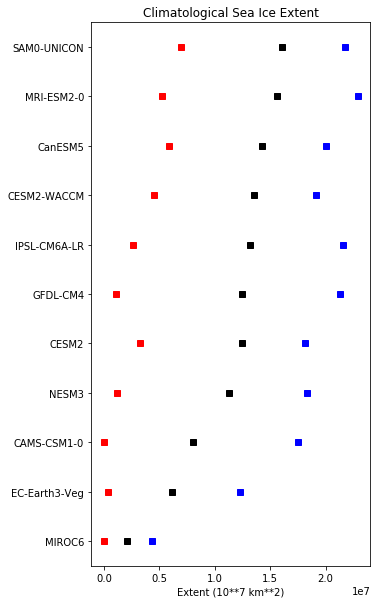

In [4]:
# Time info for calculating a climatology: all models' historical runs' output
# begins on January 1850, so figure out the indices that correspond to the months
# you want to average
year_start = 1986
nyears = 10 # number of years, beginning on year_start, to make the climatology for
months = np.arange(12*nyears) + 12*(year_start-1850) # the indices to be used later
nmonths = np.int(np.size(months))
a = 6.37E6 # m; the radius of the Earth

# New evenly spaced, monotonically increasing lat-lon grid for regridding the sea ice
# concentration for the contour plot (otherwise the contour will reverse on itself)
res_new = 1 #degrees; the resolution of the new grid
lat_new = -80 + res_new/2 + np.arange(2*80/res_new) # only go from 80S to 80N
latf_new = -80 + np.arange(1+(2*80)/res_new)
lon_new = res_new/2 + np.arange(360/res_new)
lon_new, lat_new = np.meshgrid(lon_new,lat_new)
area_new = (res_new*np.pi/180)*(a**2)*(np.sin(np.pi*latf_new[1:]/180)-np.sin(np.pi*latf_new[:-1]/180))
area_new = np.tile(area_new,(np.int(360/res_new),1)).swapaxes(0,1)
area_new_tiled = np.tile(area_new,(nmonths,1,1))

ice_edge_conc = 15 # %; the concentration threshold for the sea ice edge
ice_area = np.ndarray(shape=(nmodels,nmonths),dtype=float)
model_names = []
index = 0 # dummy index
for i in dset_dict:
    print(dset_dict[i].source_id) # to make sure the calculation hasn't stalled
    model_names.append(np.str(dset_dict[i].source_id))
    
    # Deal with diferent names for latitude and longitude coordinates
    if 'latitude' in dset_dict[i]:
        latitude = dset_dict[i].latitude
        longitude = dset_dict[i].longitude
    elif 'lat' in dset_dict[i]:
        latitude = dset_dict[i].lat
        longitude = dset_dict[i].lon
    else:
        latitude = dset_dict[i].nav_lat
        longitude = dset_dict[i].nav_lon
        
    # Deal with multiple ensemble members, 1D grid vectors
    if latitude.ndim==3:
        latitude = np.squeeze(np.array(latitude[0,:,:]))
        longitude = np.squeeze(np.array(longitude[0,:,:]))
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    elif latitude.ndim==2:
        latitude = np.array(latitude)
        longitude = np.array(longitude)
        nlat = np.size(latitude, axis=0)
        nlon = np.size(longitude, axis=1)
    else:
        nlat = np.size(latitude)
        nlon = np.size(longitude)
        latitude = np.tile(latitude,(nlon,1)).swapaxes(0,1)
        longitude = np.tile(longitude,(nlat,1))
        
    # Load in the sea ice concentration
    data = dset_dict[i].siconc[0,months,:,:]
    data = np.squeeze(np.array(data))
    ndim0 = np.size(data,axis=1)
    ndim1 = np.size(data,axis=2)
    
    # Regrid
    data_new = data
    lat_temp = latitude.copy()
    lon_temp = longitude.copy()
    method = np.str('nearest_s2d')
    # Make sure the dimensions of the new grid are in the right order
    lat_temp = lat_new.copy()
    lon_temp = lon_new.copy()
    area_temp = area_new_tiled.copy()
    if ndim0>ndim1:
        lat_temp = np.swapaxes(lat_temp,0,1)
        lon_temp = np.swapaxes(lon_temp,0,1)
        area_temp = np.swapaxes(area_temp,1,2)
    lat_temp2 = latitude.copy()
    lon_temp2 = longitude.copy()
    lat_temp2[np.abs(lat_temp2)>90] = np.nan
    lon_temp2[np.abs(lon_temp2)>360] = np.nan
    # Create the xarray datasets to feed into the xesmf regridder
    ds_in = xr.Dataset({'lat': (['x','y'],lat_temp2),
                        'lon': (['x','y'],lon_temp2)})
    ds_out = xr.Dataset({'lat': (['x','y'],lat_temp),
                            'lon': (['x','y'],lon_temp)})
    # Regrid the data
    f = xe.Regridder(ds_in, ds_out, method, periodic=True, reuse_weights=True)
    data_new = f(data)
    
    # Find the grid cells with sea ice concentrations exceeding the threshold,
    # and multiply by the grid cell area
    mydata_new = data_new.copy()
    mydata_new[mydata_new<ice_edge_conc] = 0
    mydata_new[mydata_new>=ice_edge_conc] = 1
    mydata_new = mydata_new*area_temp
    
    # A data mask to isolate SH sea ice, then sum up the ice areas
    lat_temp = np.tile(lat_temp,(nmonths,1,1))
    mydata_new = ma.masked_where(lat_temp>0.,mydata_new.copy())
    mydata_new = np.nansum(mydata_new,axis=1)
    mydata_new = np.nansum(mydata_new,axis=1) # this is now total area for each month
    ice_area[index,:] = mydata_new
    
    index = index+1
    
# Calculate annual means and monthly mean climatologies
ice_area_ann = np.ndarray(shape=(nmodels,nyears),dtype=float) # annual mean
ice_area_clim = np.ndarray(shape=(nmodels,12),dtype=float) # monthly mean climatology
for i in np.arange(nyears):
    ind = 12*i + np.arange(12)
    ice_area_ann[:,i] = np.nanmean(ice_area[:,ind],axis=1)
for i in np.arange(12):
    ind = i + 12*np.arange(nyears)
    ice_area_clim[:,i] = np.nanmean(ice_area[:,ind],axis=1)
ice_area_clim_amp = np.nanmax(ice_area_clim,axis=1)-np.nanmin(ice_area_clim,axis=1)

# Plot the annual mean, seasonal minimum, and seasonal maximum sea ice extent,
# sorted by the annual mean value.
temp = np.mean(ice_area,axis=1)/1E6 # annual mean
temp2 = np.min(ice_area_clim,axis=1)/1E6 # seasonal min
temp3 = np.max(ice_area_clim,axis=1)/1E6 # seasonal max
ind = np.argsort(temp) #sorting indices
# re-order the extents
temp = temp[ind]
temp2 = temp2[ind]
temp3 = temp3[ind]
# re-order the model name list
modelout = list()
for n in range(len(ind)):
    modelout.append(model_names[np.int(ind[n])])
# Plot
fig = plt.figure(figsize=(5,10))
plt.plot(temp,modelout,'ks') # annual mean
plt.plot(temp2,modelout,'rs') # seasonal min
plt.plot(temp3,modelout,'bs') # seasonal max
plt.title('Climatological Sea Ice Extent')
plt.xlabel('Extent (10**7 km**2)');
#fig.savefig('ice_extent_clim.eps', format='eps', bbox_inches='tight');